<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Time-Series-Prediction" data-toc-modified-id="Time-Series-Prediction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Series Prediction</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#Dense" data-toc-modified-id="Dense-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dense</a></span></li><li><span><a href="#Convolutional" data-toc-modified-id="Convolutional-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Convolutional</a></span></li></ul></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison</a></span></li><li><span><a href="#TASK-1:-Tune-hyperparameters" data-toc-modified-id="TASK-1:-Tune-hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TASK 1: Tune hyperparameters</a></span></li><li><span><a href="#TASK-2:-Bidirectional-LSTM" data-toc-modified-id="TASK-2:-Bidirectional-LSTM-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TASK 2: Bidirectional LSTM</a></span></li><li><span><a href="#TASK-3:-Atrous-Convolutions" data-toc-modified-id="TASK-3:-Atrous-Convolutions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TASK 3: Atrous Convolutions</a></span></li><li><span><a href="#TASK-4:-Preprocessing" data-toc-modified-id="TASK-4:-Preprocessing-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>TASK 4: Preprocessing</a></span></li></ul></div>

<a id='begin'></a>
# Time Series Prediction

In this notebook we're going to investigate the topic of time series prediction. As an example of time series we took [number of international airlines passangers](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) from January 1949 to December 1960. In total we 12 years of monthly data which means 144 points.

One can also investigate following usefull resources:
* [LSTM Neural Network for Time Series Prediction](http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction)
* [Time Series Prediction With Deep Learning in Keras](http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/)

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import check_array

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Convolution1D, MaxPooling1D

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Fix random seed for reproducibility

In [3]:
np.random.seed(1234)

# Data

Reading

In [4]:
data = pd.read_csv("./international-airline-passengers.csv", 
                   names=["Date", "Passengers"], skiprows=1)
data = data["Passengers"].values
data = data.reshape(-1, 1)

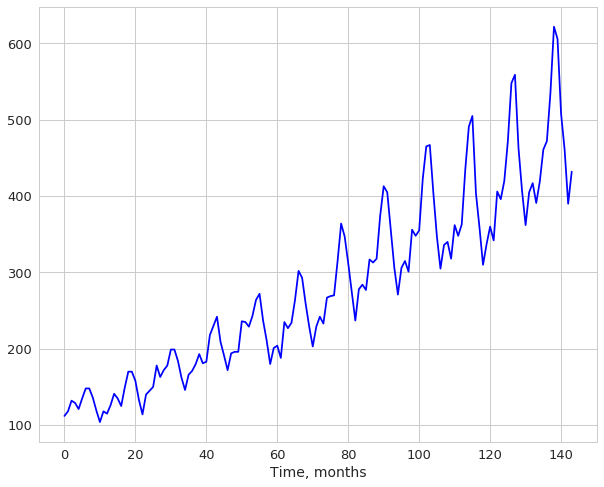

In [5]:
plt.plot(data, "b")
plt.xlabel("Time, months", fontsize=14)
plt.show()

Scaling to [0;1]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Let's set prediction horizon to 36 (3 years). It means that we need to split time series in such a way that test test set contains 36 points (it's a good practice in time series prediction field to have the same number of points in test set and prediction horizont). For time series it is also important that points in both train and test series are in their chronological order. Thus the common choice here is just to take last point of the data for validation

In [7]:
split_index = -36

How many points in the history do we want to look at during prediction. And how many points do we want to predict

In [8]:
look_back = 24
horizont = 36

Splitting. Notice that for test data we include some point from train. This is done to be able to predict test points starting from first (otherwise only 25th and later test points will be predicted because we need at least 24 points for predicting)

In [9]:
data_train, data_test = data[:split_index], data[split_index - look_back:]

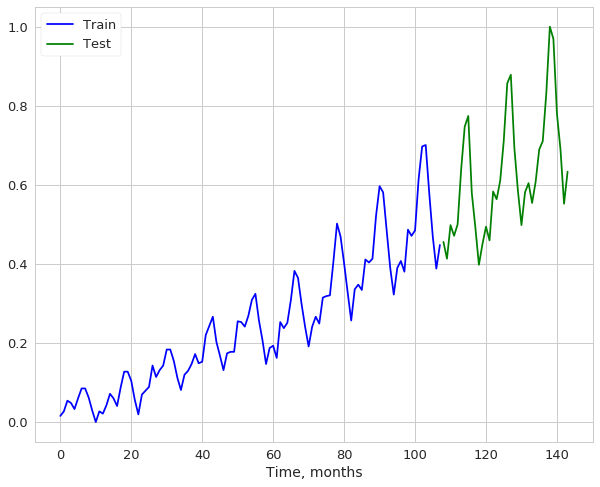

In [10]:
plt.plot(data_train, 
         "b",
         label="Train")
plt.plot(np.arange(len(data_train), len(data_train) + len(data_test[look_back:])), 
         data_test[look_back:], 
         "g",
         label="Test")
plt.legend()
plt.xlabel("Time, months", fontsize=14)
plt.show()

Function that creates dataset from raw time series. 

Each object has two dimensions:
* $\text{Time}$ $-$ contains timesteps into the past; in our case there are 24 timesteps for each object.
* $\text{Feature}$ $-$ contains features of every timestep; in our case the only feature is the value of the time series, but there can be few (e.g. if one measurement has few features or we want to predict multiple time series at the same time).

In [11]:
def create_dataset(data, look_back=1, horizont=1):
    X, Y = [], []
    for i in range(len(data) - look_back - horizont + 1):
        X.append(data[i : (i + look_back), 0])
        Y.append(data[i + look_back : i + look_back + horizont, 0])
    X = np.array(X)
    Y = np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

In [12]:
X_train, y_train = create_dataset(data_train, look_back, horizont)
X_test, y_test = create_dataset(data_test, look_back, horizont)

Finally we have our 3-dimensional tensor with data:

In [13]:
X_train.shape

(49, 24, 1)

In [14]:
X_test.shape

(1, 24, 1)

# Models

We're going to use three types of models:
* Recurrent (LSTM)
* Multi-Layer Perceptron (Dense)
* Convolutional

In [15]:
results = pd.DataFrame(columns=["RMSE", "MAE", "MAPE"])

## LSTM

We have very few data. So we need to build very simple model not tot overfit

In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(6, input_shape=(look_back, 1)))
model_lstm.add(Dense(horizont))

We do the prediction task and common error in such tasks is Mean Squared Error (MSE)

In [17]:
model_lstm.compile(loss='mse', optimizer='adam')

In [18]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 36)                252       
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________


Training

In [19]:
%%time
hist_lstm = model_lstm.fit(X_train, y_train, 
                           epochs=50, batch_size=1, verbose=0, 
                           validation_data=(X_test, y_test))

CPU times: user 3min 47s, sys: 36.2 s, total: 4min 23s
Wall time: 2min 2s


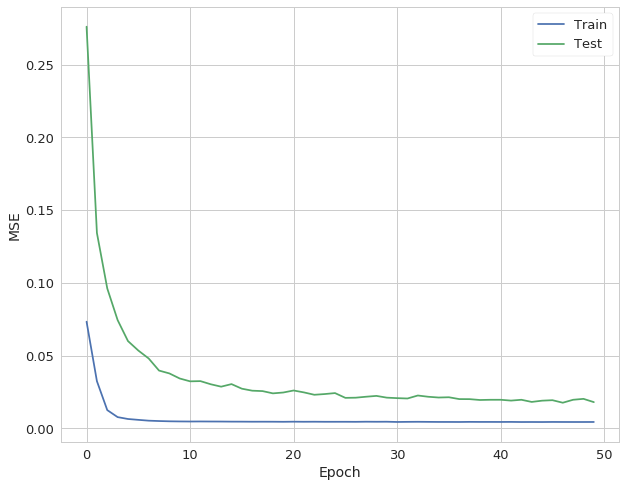

In [20]:
plt.plot(hist_lstm.history["loss"], label="Train")
plt.plot(hist_lstm.history["val_loss"], label="Test")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE", fontsize=14);

Evaluation

In [21]:
preds_test_lstm = model_lstm.predict(X_test)
preds_train_lstm = model_lstm.predict(X_train)

Below there are two functions that to plot the results and calculate different metrics.

Also I implement MAPE metric.

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Use of this metric is not recommended because can cause division by zero
    See other regression metrics on sklearn docs:
      http://scikit-learn.org/stable/modules/classes.html#regression-metrics
    Use like any other metric
    >>> y_true = [3, -0.5, 2, 7]; y_pred = [2.5, -0.3, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    Out[]: 24.791666666666668
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
def plot_results(data_train, data_test, preds_train, preds_test, look_back, horizont):
    plt.plot(data_train, 
             "--b",
             lw=1, 
             label="Train")
    plt.plot(np.arange(len(data_train), len(data_train) + len(data_test[look_back:])), 
             data_test[look_back:],
             "--g",
             lw=1,
             label="Test")
    # We need to form a predicted series from the overlapping predicted intervals of the series.
    # One way (naive) to do so is to take only the prediction at which the horizont for this point is equal to 1, 
    # which means that all the data before are known. Other (more comprehensive) way can be to take predictions
    # from different horizons with different weights (e.g. exponentially decaying into the past) as many others
    predicted_train_series = preds_train[-1]
    for i in range(1, len(preds_train)):
        predicted_train_series = np.append(preds_train[-i][:1], predicted_train_series)
    predicted_test_series = preds_test[-1]
    for i in range(1, len(preds_test)):
        predicted_test_series = np.append(preds_test[-i][:1], predicted_test_series)
    plt.plot(np.arange(look_back, len(data_train)), 
             predicted_train_series, 
             "b",
             lw=3,
             label="Predicted Train")
    plt.plot(np.arange(len(data_train), len(data_train) + len(data_test[look_back:])), 
             predicted_test_series, 
             "g",
             lw=3,
             label="Predicted Test")
    plt.legend()
    plt.xlabel("Time, months", fontsize=14)

In [24]:
def estimate_results(y_true, y_pred):
    rmse = np.round(mean_squared_error(y_true, y_pred) ** 0.5, 2)
    mae = np.round(mean_absolute_error(y_true, y_pred), 2)
    mape = np.round(mean_absolute_percentage_error(y_true, y_pred), 2)
    return rmse, mae, mape

def print_results(y_true, y_pred):
    rmse, mae, mape = estimate_results(y_true, y_pred)
    print("RMSE =", rmse)
    print("MAE =", mae)
    print("MAPE =", mape)

Visualization

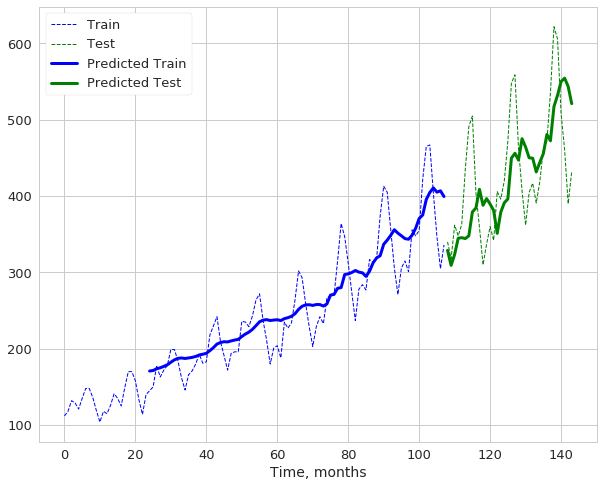

In [25]:
plot_results(scaler.inverse_transform(data_train), 
             scaler.inverse_transform(data_test), 
             scaler.inverse_transform(preds_train_lstm), 
             scaler.inverse_transform(preds_test_lstm), 
             look_back, horizont)

In [26]:
print_results(scaler.inverse_transform(y_test), 
              scaler.inverse_transform(preds_test_lstm))

RMSE = 69.68
MAE = 57.09
MAPE = 13.1


In [27]:
results = results.append(pd.DataFrame(
        [list(estimate_results(scaler.inverse_transform(y_test), scaler.inverse_transform(preds_test_lstm)))], 
        columns=["RMSE", "MAE", "MAPE"], 
        index=["LSTM"]))
results

,RMSE,MAE,MAPE
LSTM,69.68,57.09,13.1


## Dense

In dense model we're not going to flatten all the input for one object into one feature vector (of size $\text{N}_{\text{timesteps}} \times \text{N}_{\text{features}}$). This is done below using numpy function $\text{squeeze}$

In [28]:
model_dense = Sequential()
model_dense.add(Dense(8, input_shape=(look_back,), activation="relu"))
model_dense.add(Dense(horizont))

In [29]:
model_dense.compile(loss='mse', optimizer='adam')

In [30]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_3 (Dense)              (None, 36)                324       
Total params: 524
Trainable params: 524
Non-trainable params: 0
_________________________________________________________________


Training

In [31]:
%%time
hist_dense = model_dense.fit(np.squeeze(X_train, axis=2), y_train, 
                             epochs=100, batch_size=1, verbose=0, 
                             validation_data=(np.squeeze(X_test, axis=2), y_test))

CPU times: user 25.7 s, sys: 6.1 s, total: 31.8 s
Wall time: 11.7 s


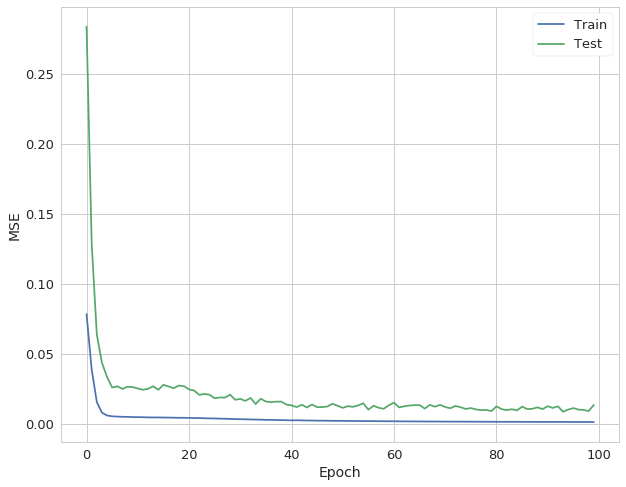

In [32]:
plt.plot(hist_dense.history["loss"], label="Train")
plt.plot(hist_dense.history["val_loss"], label="Test")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE", fontsize=14);

Evaluation

In [33]:
preds_test_dense = model_dense.predict(np.squeeze(X_test, axis=2))
preds_train_dense = model_dense.predict(np.squeeze(X_train, axis=2))

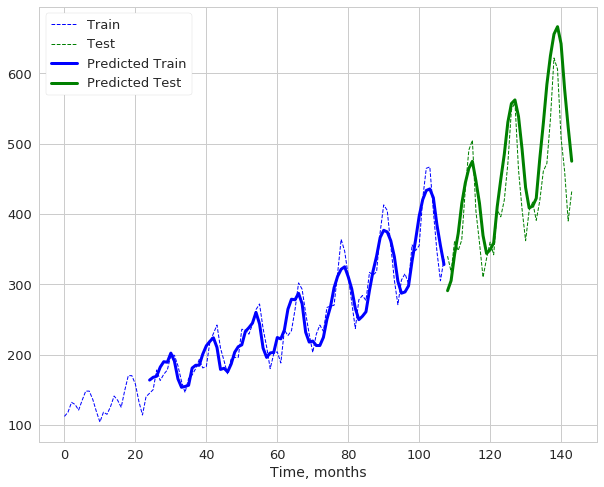

In [34]:
plot_results(scaler.inverse_transform(data_train), 
             scaler.inverse_transform(data_test), 
             scaler.inverse_transform(preds_train_dense), 
             scaler.inverse_transform(preds_test_dense), 
             look_back, horizont)

In [35]:
print_results(scaler.inverse_transform(y_test), 
              scaler.inverse_transform(preds_test_dense))

RMSE = 60.66
MAE = 48.32
MAPE = 11.34


In [36]:
results = results.append(pd.DataFrame(
        [list(estimate_results(scaler.inverse_transform(y_test), scaler.inverse_transform(preds_test_dense)))], 
        columns=["RMSE", "MAE", "MAPE"], 
        index=["Dense"]))
results

,RMSE,MAE,MAPE
LSTM,69.68,57.09,13.10
Dense,60.66,48.32,11.34


## Convolutional

All the same for Convolutional NN model.

Here we're going to use two convolutional layers (with length 3 and stride 1) followed by max pooling (with length 2 and stride 2)

In [37]:
model_conv = Sequential()
model_conv.add(Convolution1D(filters=8, kernel_size=3, input_shape=(look_back,1)))
model_conv.add(Convolution1D(filters=8, kernel_size=3))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(horizont))

In [38]:
model_conv.compile(loss='mse', optimizer='adam')

In [39]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 22, 8)             32        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 8)             200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 8)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                2916      
Total params: 3,148
Trainable params: 3,148
Non-trainable params: 0
_________________________________________________________________


Training

In [40]:
%%time
hist_conv = model_conv.fit(X_train, y_train, 
                           epochs=100, batch_size=1, verbose=0, 
                           validation_data=(X_test, y_test))

CPU times: user 40.1 s, sys: 7.79 s, total: 47.9 s
Wall time: 21 s


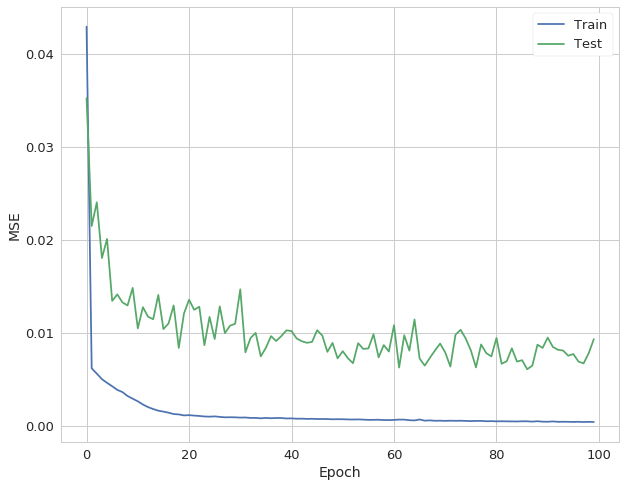

In [41]:
plt.plot(hist_conv.history["loss"], label="Train")
plt.plot(hist_conv.history["val_loss"], label="Test")
plt.grid("on")
plt.legend()
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE", fontsize=14);

Evaluation

In [42]:
preds_test_conv = model_conv.predict(X_test)
preds_train_conv = model_conv.predict(X_train)

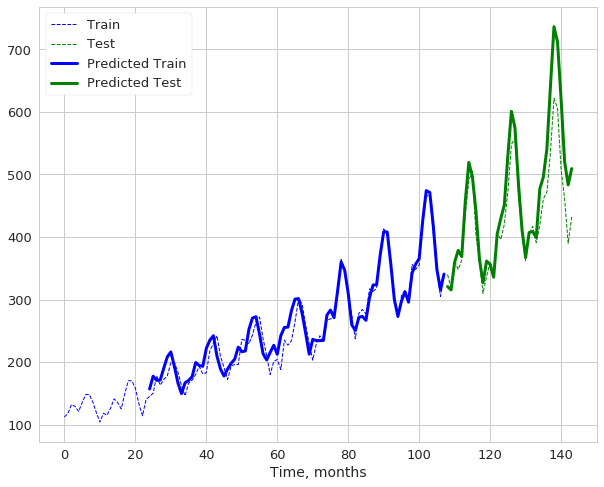

In [43]:
plot_results(scaler.inverse_transform(data_train), 
             scaler.inverse_transform(data_test), 
             scaler.inverse_transform(preds_train_conv), 
             scaler.inverse_transform(preds_test_conv), 
             look_back, horizont)

In [44]:
print_results(scaler.inverse_transform(y_test), 
              scaler.inverse_transform(preds_test_conv))

RMSE = 50.03
MAE = 35.75
MAPE = 7.71


In [45]:
results = results.append(pd.DataFrame(
        [list(estimate_results(scaler.inverse_transform(y_test), scaler.inverse_transform(preds_test_conv)))], 
        columns=["RMSE", "MAE", "MAPE"], 
        index=["Convolutional"]))
results

,RMSE,MAE,MAPE
LSTM,69.68,57.09,13.10
Dense,60.66,48.32,11.34
Convolutional,50.03,35.75,7.71


# Comparison

Below one can find a table with models evaluation results:

* $\text{h} = 36$ $-$ forecasting horizont is equal to 36; forecast all the points at once

`ARIMA` and `ETS` results are taken from R notebook `ConventionalAirlines.ipynb`

In [46]:
results = results.append(pd.DataFrame(
        [[84.17, 75.67, 17.25], [61.66, 55.79, 12.72]], 
        columns=["RMSE", "MAE", "MAPE"], 
        index=["ETS", "ARIMA"]))
results

,RMSE,MAE,MAPE
LSTM,69.68,57.09,13.10
Dense,60.66,48.32,11.34
Convolutional,50.03,35.75,7.71
ETS,84.17,75.67,17.25
ARIMA,61.66,55.79,12.72


# TASK 1: Tune hyperparameters
Here we used default hyperparametrs for all of the models. Try to find out the best architectures, number of epochs etc.

# TASK 2: Bidirectional LSTM
Apply Biderectional LSTM to this task

# TASK 3: Atrous Convolutions
In this task we have strong 12-month seasonality. To catch this seasonality it may be a good idea to use convolutions with holes (atrous)

# TASK 4: Preprocessing
Can we borrow preprocessing ideas from conventional methods to improve existing solutions?